In [35]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import  roc_curve, auc ,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes = True)

In [36]:
pima = pd.read_csv('Data/diabetes.csv', sep=';')
df = pd.read_csv('Data/diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('Data/diabetes_pt2.csv', sep=';')

In [37]:
feature_columns = ['Glucose', 'BMI', 'Age']

stan2_data = {
    'N': len(df),
    'X': df[feature_columns].values,
    'y': df['Outcome'].values
}

test2_data = {
    'N': len(df_test),
    'X': df_test[feature_columns].values,
    'y': df_test['Outcome'].values
}

In [38]:
sm2 = CmdStanModel(stan_file='Stan/code_1.stan')
fit2 = sm2.sample(data=stan2_data, iter_sampling=2000, chains=4, iter_warmup=2000)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |█▏        | 00:00 Iteration:  300 / 4000 [  7%]  (Warmup)


chain 1 |█▋        | 00:00 Iteration:  500 / 4000 [ 12%]  (Warmup)
chain 1 |██▏       | 00:00 Iteration:  700 / 4000 [ 17%]  (Warmup)


chain 1 |██▌       | 00:00 Iteration:  900 / 4000 [ 22%]  (Warmup)


chain 1 |███▎      | 00:00 Iteration: 1200 / 4000 [ 30%]  (Warmup)


chain 1 |███▊      | 00:00 Iteration: 1400 / 4000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration: 1700 / 4000 [ 42%]  (Warmup)


chain 1 |█████     | 00:01 Iteration: 1900 / 4000 [ 47%]  (Warmup)


chain 1 |█████▋    | 00:01 Iteration: 2100 / 4000 [ 52%]  (Sampling)


chain 1 |██████▏   | 00:01 Iteration: 2300 / 4000 [ 57%]  (Sampling)


chain 1 |██████▋   | 00:01 Iteration: 2500 / 4000 [ 62%]  (Sampling)


chain 1 |███████▏  | 00:01 Iteration: 2700 / 4000 [ 67%]  (Sampling)




chain 1 |███████▌  | 00:01 Iteration: 2900 / 4000 [ 72%]  (Sampling)


chain 1 |████████  | 00:02 Iteration: 3100 / 4000 [ 77%]  (Sampling)



chain 1 |████████▌


INFO:cmdstanpy:CmdStan done processing.


In [39]:
betas = ['glucose', 'bmi', 'age']

df3 = fit2.draws_pd()
alpha_mean = df3['alpha'].mean()
beta_means = [df3[f'beta_{name}'].mean() for name in betas]

In [40]:
logit_preds_test = alpha_mean + np.dot(test2_data['X'], beta_means)
probs_test2 = 1 / (1 + np.exp(-logit_preds_test))

preds_test2 = (probs_test2 > 0.5).astype(int)

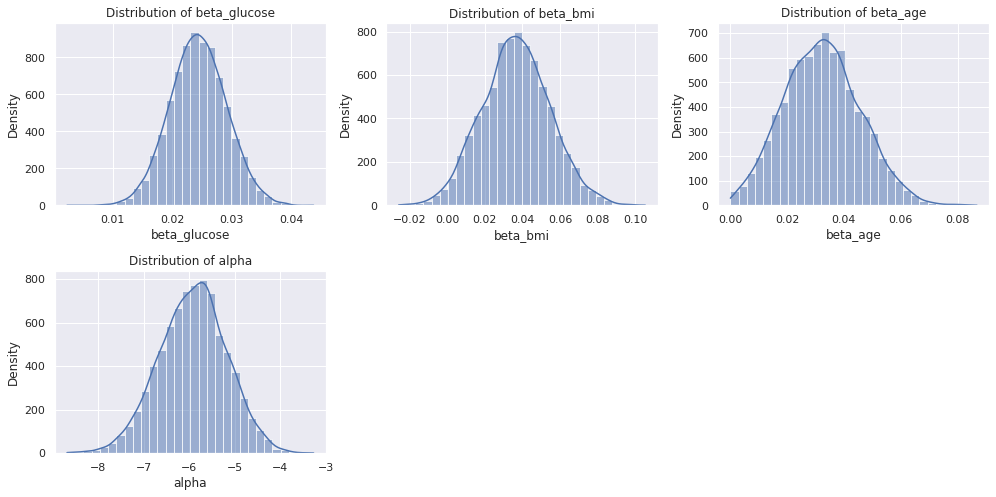

             alpha  beta_glucose     beta_bmi     beta_age
count  8000.000000   8000.000000  8000.000000  8000.000000
mean     -5.917841      0.024395     0.036576     0.032359
std       0.740983      0.004750     0.018101     0.013367
min      -8.679070      0.002270    -0.025737     0.000102
25%      -6.407658      0.021221     0.024639     0.022787
50%      -5.892280      0.024334     0.036526     0.032139
75%      -5.425215      0.027572     0.048527     0.041177
max      -3.265880      0.043825     0.105306     0.086803


In [42]:
plt.figure(figsize=(14, 10))
for i, name in enumerate(betas):
    beta_column = f'beta_{name}'
    plt.subplot(3, 3, i+1)
    sns.histplot(df3[beta_column], kde=True, bins=30)
    plt.title(f'Distribution of {beta_column}')
    plt.xlabel(beta_column)
    plt.ylabel('Density')

plt.subplot(3, 3, len(betas)+1)
sns.histplot(df3['alpha'], kde=True, bins=30)
plt.title('Distribution of alpha')
plt.xlabel('alpha')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

summary_stats = df3[['alpha'] + [f'beta_{name}' for name in betas]].describe()
print(summary_stats)

In [43]:
accuracy = accuracy_score(test2_data['y'], preds_test2)
precision = precision_score(test2_data['y'], preds_test2)
recall = recall_score(test2_data['y'], preds_test2)
f1 = f1_score(test2_data['y'], preds_test2)

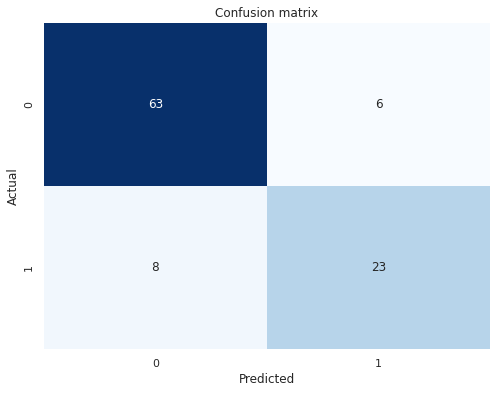

In [44]:
conf_matrix = confusion_matrix(test2_data['y'], preds_test2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [45]:
fpr, tpr, _ = roc_curve(test2_data['y'], probs_test2)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.86
Precision: 0.79
Recall: 0.74
F1 Score: 0.77


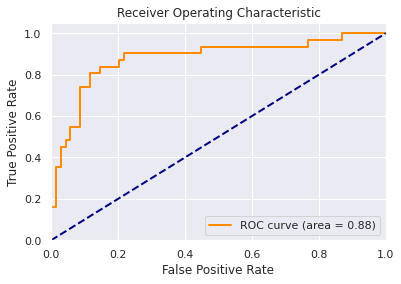

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()